In [1]:
from pyMesh import hcubeMesh, visualize2D, plotBC, plotMesh,setAxisLabel

====>Check bc nodes!
====>BC nodes pass!
The mesh generation reaches covergence!


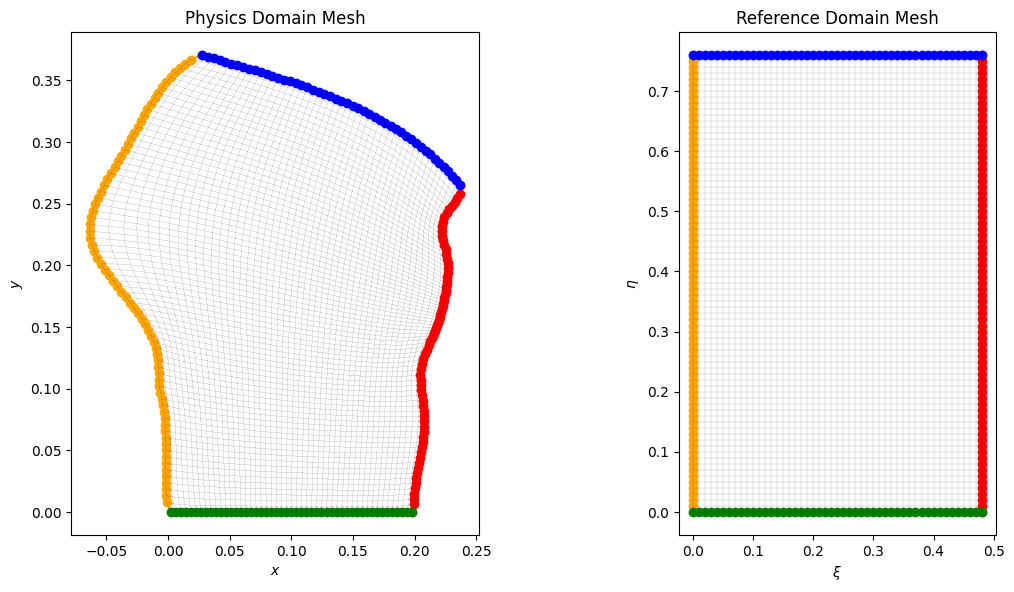

In [2]:
import Ofpp
h=0.01
OFBCCoord=Ofpp.parse_boundary_field(r'TemplateCase_simpleVessel/3200/C.txt')
OFLOWC=OFBCCoord[b'low'][b'value']
OFUPC=OFBCCoord[b'up'][b'value']
OFLEFTC=OFBCCoord[b'left'][b'value']
OFRIGHTC=OFBCCoord[b'rifht'][b'value']

leftX=OFLEFTC[:,0];leftY=OFLEFTC[:,1]
lowX=OFLOWC[:,0];lowY=OFLOWC[:,1]
rightX=OFRIGHTC[:,0];rightY=OFRIGHTC[:,1]
upX=OFUPC[:,0];upY=OFUPC[:,1]
ny=len(leftX);nx=len(lowX)
myMesh=hcubeMesh(leftX,leftY,rightX,rightY,
	             lowX,lowY,upX,upY,h,True,True,
	             tolMesh=1e-10,tolJoint=1e-2)

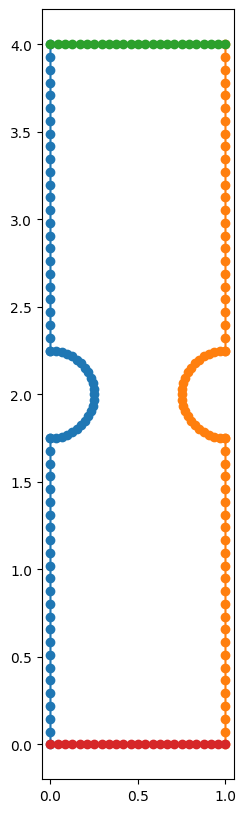

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt


# Define the parameters
height = 4
width = 1
notch_diameter = 0.5
notch_radius = notch_diameter / 2
notch_height = 2
notch_center1 = (0, 2)
notch_center2 = (1, 2)
n_points = 25

# Generate the top and bottom boundaries
top = np.array([(x, height) for x in np.linspace(0, width, n_points)])
bottom = np.array([(x, 0) for x in np.linspace(0, width, n_points)])

# Generate the left and right boundaries
left_1 = np.array([(0, y) for y in np.linspace(0, notch_height - notch_radius, n_points)])
left_2 = np.array([(0, y) for y in np.linspace(notch_height + notch_radius, height, n_points)])
left_circle = np.array([(notch_center1[0] + notch_radius * np.sin(t), notch_center1[1] + notch_radius * np.cos(t)) for t in np.linspace(np.pi, 0, n_points)])
left = np.concatenate([left_1, left_circle, left_2])

right_1 = np.array([(width, y) for y in np.linspace(0, notch_height - notch_radius, n_points)])
right_2 = np.array([(width, y) for y in np.linspace(notch_height + notch_radius, height, n_points)])
right_circle = np.array([(notch_center2[0] + notch_radius * np.sin(t), notch_center2[1] + notch_radius * np.cos(t)) for t in np.linspace(np.pi, 2 * np.pi, n_points)])
right = np.concatenate([right_1, right_circle, right_2])

fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.plot(left[:,0],left[:,1], marker='o')
plt.plot(right[:,0],right[:,1], marker='o')
plt.plot(top[:,0],top[:,1], marker='o')
plt.plot(bottom[:,0],bottom[:,1], marker='o')

ax.set_aspect('equal')


====>Check bc nodes!
====>BC nodes pass!
The mesh generation reaches covergence!


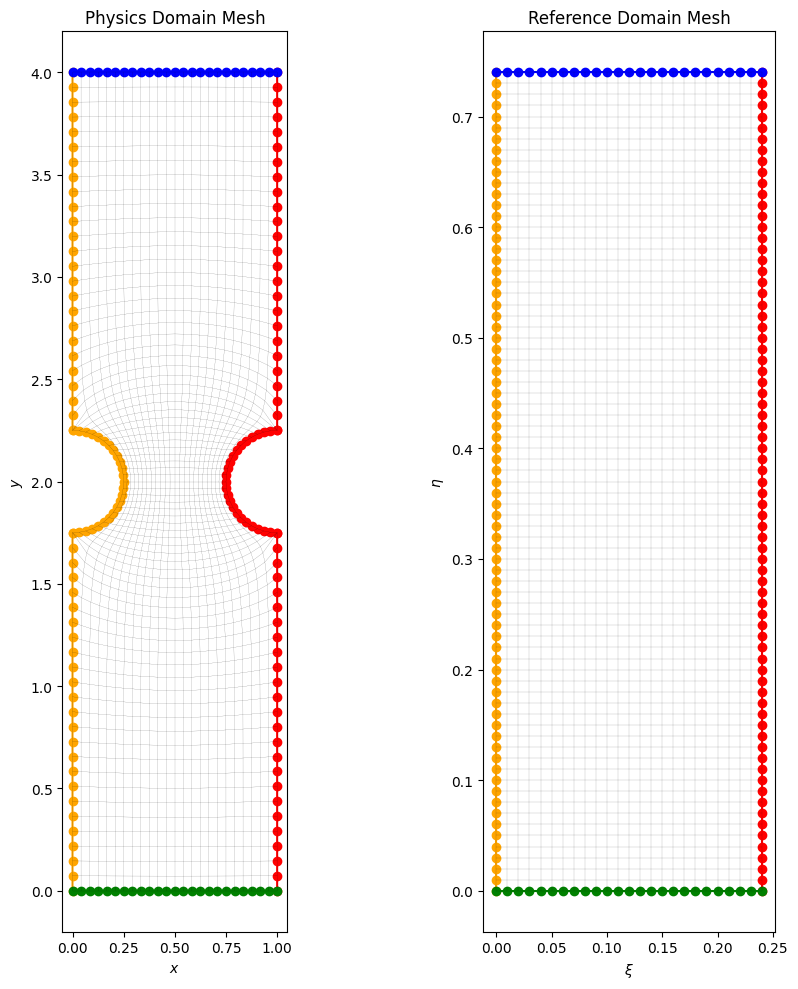

In [35]:
upX=top[:,0];upY=top[:,1]
lowX=bottom[:,0];lowY=bottom[:,1]
leftX=left[:,0];leftY=left[:,1]
rightX=right[:,0];rightY=right[:,1]

ny=len(leftX);nx=len(lowX)
myMesh=hcubeMesh(leftX,leftY,rightX,rightY,
	             lowX,lowY,upX,upY,h,False,False,
	             tolMesh=1e-10,tolJoint=1e-2)

fig, ax = plt.subplots(1, 2,figsize=(10,10))
plotBC(ax[0],myMesh.x,myMesh.y)
plotMesh(ax[0],myMesh.x,myMesh.y)
setAxisLabel(ax[0],'p')
ax[0].set_aspect('equal')
ax[0].set_title('Physics Domain Mesh')

plotBC(ax[1],myMesh.xi,myMesh.eta)
plotMesh(ax[1],myMesh.xi,myMesh.eta)
setAxisLabel(ax[1],'r')
ax[1].set_aspect('equal')
ax[1].set_title('Reference Domain Mesh')
fig.tight_layout()